In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from scipy.stats import linregress

This notebook analyzes the data available in the DFA recommender paper, in the original VSS-452 and CSD-76 datasets.

In [2]:
vss_df = pd.read_csv('../data/VSS-452.csv')
csd_df = pd.read_csv('../data/CSD-76.csv')

to_remove = []
for idx, row in csd_df.iterrows():
    if 'Cr' in row['name']:
        to_remove.append(idx)

csd_df = csd_df.drop(to_remove)

# Variations in the MAE with HFX

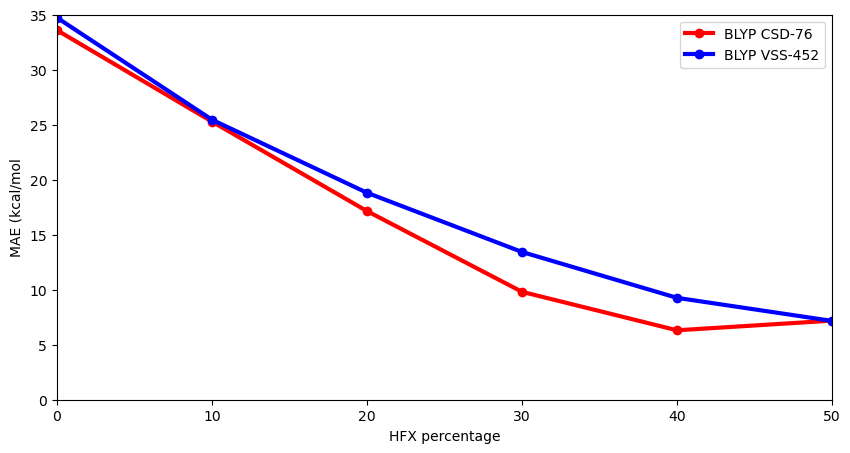

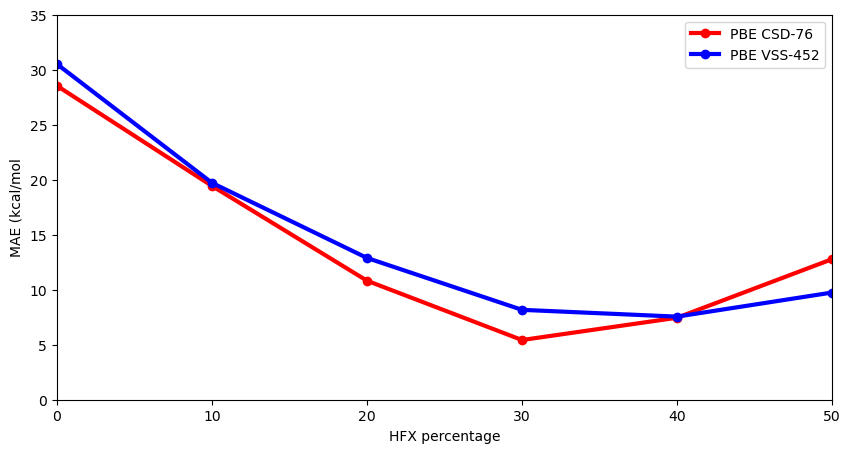

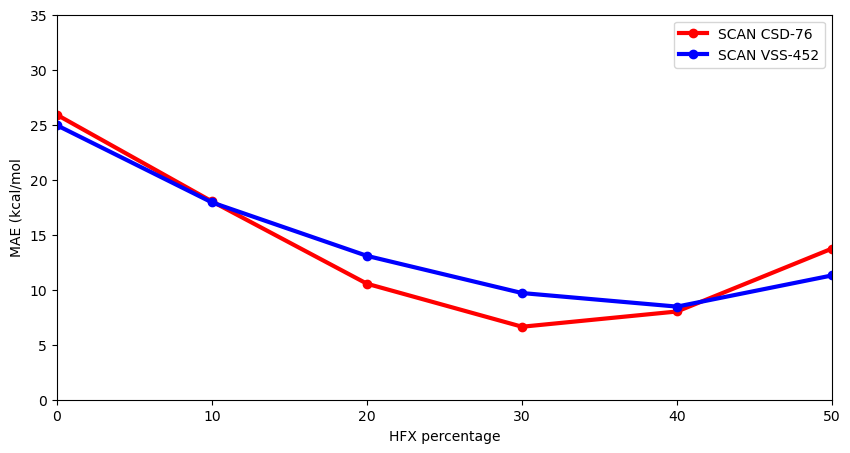

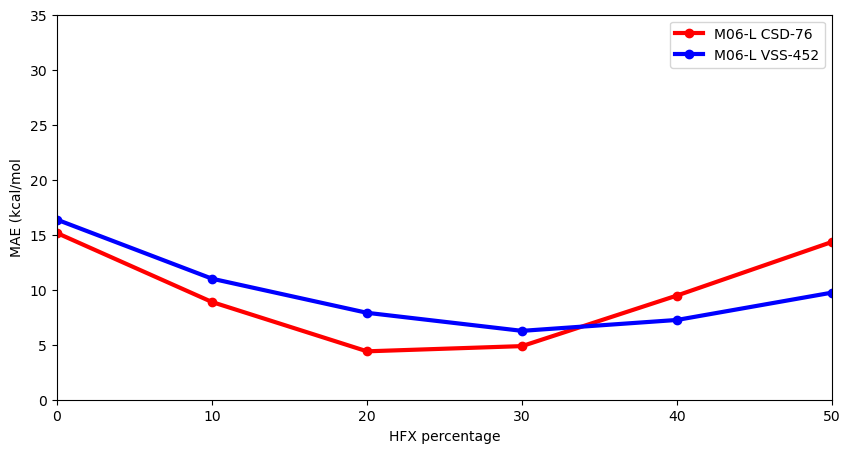

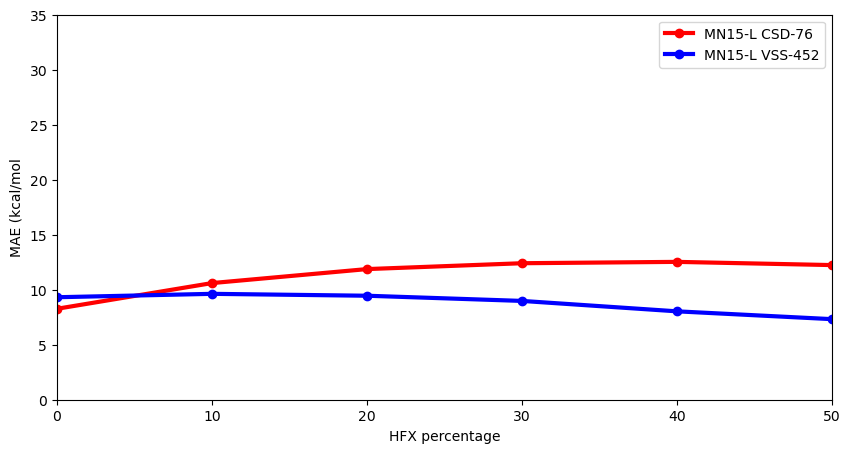

In [3]:
functionals = ['blyp', 'pbe', 'scan', 'm06-l', 'mn15-l']
hfx_amounts = ['10', '20', '30', '40', '50']

for base_functional in functionals:
    plt.figure(figsize=(10,5))
    for idx, df in enumerate([csd_df, vss_df]):
        errors = []
        base_mae = np.abs(np.array([item for item in df[f'delta.{base_functional}.vertsse'].to_list() if not np.isnan(item)])).mean()
        errors.append(base_mae)
        for functional in [base_functional + '_hfx_' + hfx for hfx in hfx_amounts]:
            mae = np.abs(np.array([item for item in df[f'delta.{functional}.vertsse'].to_list() if not np.isnan(item)])).mean()
            errors.append(mae)
        label = base_functional.upper() + ' CSD-76' if idx == 0 else base_functional.upper() + ' VSS-452'
        color = '#FF0000' if idx == 0 else '#0000FF'
        plt.plot(np.arange(0, 51, 10), errors, label=label, linewidth=3, color=color, marker='o')
    plt.ylim(0, 35)
    plt.xlim(0, 50)
    plt.xlabel('HFX percentage')
    plt.ylabel('MAE (kcal/mol')
    plt.legend();

# Linearity of HFX-adjusted Semilocal Functionals

In [5]:
functionals = ['blyp', 'pbe', 'scan', 'm06-l', 'mn15-l']
hfx_amounts = ['10', '20', '30', '40', '50']

for base_functional in functionals:
    print(f'For functional {base_functional.upper()}:')
    print('=====================')
    for jdx, df in enumerate([csd_df, vss_df]):
        r2_values = []
        max_errors = []
        for _, row in df.iterrows():
            hfxs = []
            vsses = []
            if not np.isnan(row[f'{base_functional}.vertsse']):
                hfxs.append(0)
                vsses.append(row[f'{base_functional}.vertsse'])
            for hfx in hfx_amounts:
                functional = base_functional + '_hfx_' + hfx
                if not np.isnan(row[f'{functional}.vertsse']):
                    hfxs.append(int(hfx))
                    vsses.append(row[f'{functional}.vertsse'])
            fit = linregress(hfxs, vsses)
            r2_values.append(fit.rvalue ** 2)
            max_error = -np.inf
            for idx, vsse in enumerate(vsses):
                hfx = hfxs[idx]
                error = np.abs(vsse - (fit.slope*hfx + fit.intercept))
                if error > max_error:
                    max_error = error
            max_errors.append(max_error)

        r2_values = np.array(r2_values)
        max_errors = np.array(max_errors)
        
        if jdx == 0:
            print('For CSD-76:')
        else:
            print('For VSS-452:')
        print(f'The mean r2 value is {np.mean(r2_values)}.')
        print(f'The median r2 value is {np.median(r2_values)}.')
        print(f'The mean maximum error for the linear fit is {np.mean(max_errors)}.')
        print(f'The median maximum error for the linear fit is {np.median(max_errors)}.')
        
        print('\n')

For functional BLYP:
For CSD-76:
The mean r2 value is 0.993547051950569.
The median r2 value is 0.9975240894043049.
The mean maximum error for the linear fit is 1.1985180151491213.
The median maximum error for the linear fit is 1.0044994905939806.


For VSS-452:
The mean r2 value is 0.9774289081043052.
The median r2 value is 0.991393077353983.
The mean maximum error for the linear fit is 1.814362774856013.
The median maximum error for the linear fit is 1.254573963891012.


For functional PBE:
For CSD-76:
The mean r2 value is 0.9930391338046647.
The median r2 value is 0.9964724748682003.
The mean maximum error for the linear fit is 1.340343563518871.
The median maximum error for the linear fit is 1.1959483408628504.


For VSS-452:
The mean r2 value is 0.976006849389993.
The median r2 value is 0.9905709467810593.
The mean maximum error for the linear fit is 1.9756916600398584.
The median maximum error for the linear fit is 1.381617451392799.


For functional SCAN:
For CSD-76:
The mean r2

# Summary of Optimal HFX Values

In [4]:
functionals = ['blyp', 'pbe', 'scan', 'm06-l', 'mn15-l']
hfx_amounts = ['10', '20', '30', '40', '50']

for base_functional in functionals:
    print(f'For functional {base_functional.upper()}:')
    print('=====================')
    for idx, df in enumerate([csd_df, vss_df]):
        optimal_hfx = []
        for _, row in df.iterrows():
            optimal_vsse = row['dlpno-CCSD_T.vertsse']
            hfxs = []
            vsses = []
            if not np.isnan(row[f'{base_functional}.vertsse']):
                hfxs.append(0)
                vsses.append(row[f'{base_functional}.vertsse'])
            for hfx in hfx_amounts:
                functional = base_functional + '_hfx_' + hfx
                if not np.isnan(row[f'{functional}.vertsse']):
                    hfxs.append(int(hfx))
                    vsses.append(row[f'{functional}.vertsse'])
            fit = interp1d(hfxs, vsses, kind='linear', fill_value='extrapolate')
            sse_intersection = lambda hfx: (fit(hfx) - optimal_vsse)**2
            res = minimize(sse_intersection, 25, method='Nelder-Mead')
            if res.success:
                optimal_hfx.append(res.x[0])

        optimal_hfx = np.array(optimal_hfx)
        if idx == 0:
            print('For CSD-76:')
        else:
            print('For VSS-452:')
        print(f'The mean correct HFX is {np.mean(optimal_hfx)}.')
        print(f'The standard deviation of correct HFX is {np.std(optimal_hfx)}.')
        print(f'The median correct HFX is {np.median(optimal_hfx)}.')
        print(f'The 25th percentile of correct HFX is {np.percentile(optimal_hfx, 25)}.')
        print(f'The 75th percentile correct HFX is {np.percentile(optimal_hfx, 75)}.')
        print(f'The number of correct HFX less than 0 is {np.sum(optimal_hfx < 0)}.')
        print(f'The number of correct HFX greater than 50 is {np.sum(optimal_hfx > 50)}.')
        print(f'The number of correct HFX greater than 100 is {np.sum(optimal_hfx > 100)}.')
        print('\n')

For functional BLYP:
For CSD-76:
The mean correct HFX is 44.67562357584635.
The standard deviation of correct HFX is 12.507822861188094.
The median correct HFX is 44.26971435546875.
The 25th percentile of correct HFX is 34.540767669677734.
The 75th percentile correct HFX is 50.41412353515625.
The number of correct HFX less than 0 is 0.
The number of correct HFX greater than 50 is 21.
The number of correct HFX greater than 100 is 0.


For VSS-452:
The mean correct HFX is 56.31811749618665.
The standard deviation of correct HFX is 27.19034031609502.
The median correct HFX is 50.406341552734375.
The 25th percentile of correct HFX is 45.219879150390625.
The 75th percentile correct HFX is 62.3173713684082.
The number of correct HFX less than 0 is 2.
The number of correct HFX greater than 50 is 235.
The number of correct HFX greater than 100 is 16.


For functional PBE:
For CSD-76:
The mean correct HFX is 33.919105529785156.
The standard deviation of correct HFX is 10.164594781731246.
The me

In [7]:
# structures with optimal HFX >100 or <0 for BLYP

import json

functionals = ['blyp']
hfx_amounts = ['10', '20', '30', '40', '50']

for base_functional in functionals:
    print(f'For functional {base_functional.upper()}:')
    print('=====================')
    for idx, df in enumerate([csd_df, vss_df]):
        if idx == 0:
            print('For CSD-76:')
        else:
            print('For VSS-452:')
        optimal_hfx = []
        for _, row in df.iterrows():
            optimal_vsse = row['dlpno-CCSD_T.vertsse']
            hfxs = []
            vsses = []
            if not np.isnan(row[f'{base_functional}.vertsse']):
                hfxs.append(0)
                vsses.append(row[f'{base_functional}.vertsse'])
            for hfx in hfx_amounts:
                functional = base_functional + '_hfx_' + hfx
                if not np.isnan(row[f'{functional}.vertsse']):
                    hfxs.append(int(hfx))
                    vsses.append(row[f'{functional}.vertsse'])
            fit = interp1d(hfxs, vsses, kind='linear', fill_value='extrapolate')
            sse_intersection = lambda hfx: (fit(hfx) - optimal_vsse)**2
            res = minimize(sse_intersection, 25, method='Nelder-Mead')
            if res.success:
                optimal_hfx.append(res.x[0])
                if res.x[0] > 100 or res.x[0] < 0:
                    print(row['name'], res.x[0])

        optimal_hfx = np.array(optimal_hfx)

For functional BLYP:
For CSD-76:
For VSS-452:
co_2_SH2-S-0-0_SH2-S-0-0_SH2-S-0-0_SH2-S-0-0_fluoride-F-0-d1_fluoride-F-0-d1_4 105.25550842285156
co_2_SH2-S-0-0_SH2-S-0-0_SH2-S-0-0_water-O-0-0_water-O-0-0_water-O-0-0_4 100.96694946289062
co_2_furan-O-0-0_furan-O-0-0_furan-O-0-0_furan-O-0-0_chloride-Cl-0-d1_chloride-Cl-0-d1_4 130.08216857910156
cr_2_imidazole-N-2-0_imidazole-N-2-0_imidazole-N-2-0_imidazole-N-2-0_furan-O-0-0_furan-O-0-0_5 108.89961242675781
cr_2_imidazole-N-2-0_imidazole-N-2-0_imidazole-N-2-0_imidazole-N-2-0_ome2-O-0-0_ome2-O-0-0_5 102.69523620605469
cr_2_ome2-O-0-0_ome2-O-0-0_ome2-O-0-0_thiocyanate-S-0-d1_thiocyanate-S-0-d1_thiocyanate-S-0-d1_5 108.50563049316406
cr_3_acetonitrile-N-1-0_acetonitrile-N-1-0_acetonitrile-N-1-0_carbonyl-C-0-0_acetonitrile-N-1-0_carbonyl-C-0-0_4 224.5501708984375
cr_3_chloride-Cl-0-d1_chloride-Cl-0-d1_chloride-Cl-0-d1_chloride-Cl-0-d1_SH2-S-0-0_SH2-S-0-0_4 212.83485412597656
cr_3_cs-C-0-0_cs-C-0-0_cs-C-0-0_cs-C-0-0_cs-C-0-0_thiocyanate-S-0-d1_

# Minimum MAE

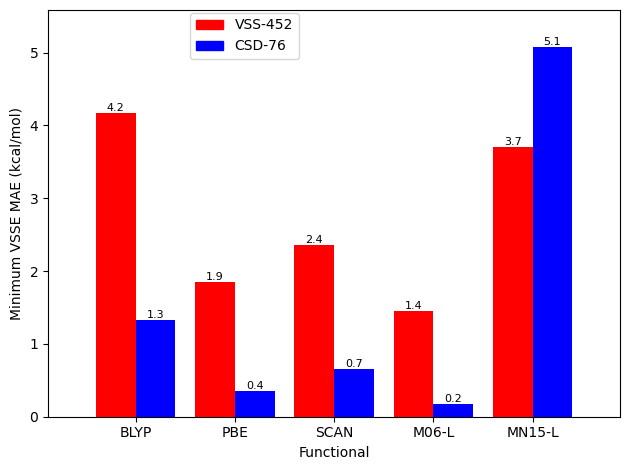

In [9]:
functionals = ['blyp', 'pbe', 'scan', 'm06-l', 'mn15-l']
hfx_amounts = ['10', '20', '30', '40', '50']

csd_mae = []
vss_mae = []

for base_functional in functionals:
    for idx, df in enumerate([csd_df, vss_df]):
        errors = []
        for _, row in df.iterrows():
            optimal_vsse = row['dlpno-CCSD_T.vertsse']
            hfxs = []
            vsses = []
            if not np.isnan(row[f'{base_functional}.vertsse']):
                hfxs.append(0)
                vsses.append(row[f'{base_functional}.vertsse'])
            for hfx in hfx_amounts:
                functional = base_functional + '_hfx_' + hfx
                if not np.isnan(row[f'{functional}.vertsse']):
                    hfxs.append(int(hfx))
                    vsses.append(row[f'{functional}.vertsse'])
            fit = interp1d(hfxs, vsses, kind='linear', fill_value='extrapolate')
            sse_intersection = lambda hfx: (fit(hfx) - optimal_vsse)**2
            res = minimize(sse_intersection, 25, method='Nelder-Mead')
            if res.success:
                if res.x[0] > 50:
                    hfx = 50
                elif res.x[0] < 0:
                    hfx = 0
                else:
                    hfx = res.x[0]
                errors.append(np.abs(fit(hfx) - optimal_vsse))

        if idx == 0:
            csd_mae.append(np.mean(np.array(errors)))
        else:
            vss_mae.append(np.mean(np.array(errors)))

functionals_tot = []
for functional in functionals:
    functionals_tot.append(functional.upper() +'\n' + 'VSS-452')
    functionals_tot.append(functional.upper() +'\n' + 'CSD-76')

errors_tot = []
for i in range(5):
    errors_tot.append(vss_mae[i])
    errors_tot.append(csd_mae[i])

colors = ['#FF0000', '#0000FF']
sizes = np.arange(5)

fig, ax = plt.subplots()
ax.bar(sizes-0.2, vss_mae, 0.4, color=colors[0], label='VSS-452')
ax.bar_label(ax.containers[0], fmt=lambda x: f'{x:1.1f}', label_type='edge', fontsize=8)
ax.bar(sizes+0.2, csd_mae, 0.4, color=colors[1], label='CSD-76')
ax.bar_label(ax.containers[1], fmt=lambda x: f'{x:1.1f}', label_type='edge', fontsize=8)
ax.set_xticks(np.arange(5), [f.upper() for f in functionals])
ax.set_xlabel('Functional')
ax.set_ylabel('MAE (kcal/mol)')
ax.margins(x=0.1, y=0.1)

import matplotlib.patches as mpatches
patch0 = mpatches.Patch(color='#FF0000', label='VSS-452')
patch1 = mpatches.Patch(color='#0000FF', label='CSD-76')
ax.set_xlabel('Functional')
ax.set_ylabel('Minimum VSSE MAE (kcal/mol)')
ax.legend(handles=[patch0, patch1], bbox_to_anchor=(0.45, 1.01))
fig.tight_layout()